In [1]:
import numpy as np

import pandas as pd
import xarray as xr
import glob

from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

import cartopy.io.shapereader as shapereader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import scipy.stats as st



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import preseason.tools as sf
import preseason.onset_demise as od
import preseason.plotting as pp

In [3]:
### Peru Domain ###
#min_lon = -83+360
#min_lat = -20.0
#max_lon = -67+360
#max_lat = 0.0



### processing CPC data 


cpc_files = glob.glob('/Users/gbromley/data/cpc_uni_global/precip.*.nc')
cpc_raw = xr.open_mfdataset(cpc_files)

### Setting coordinate data for next step 
lat = np.arange(-90, 90, 0.5)
lon = np.arange(0, 360, 0.5)
time = cpc_raw['time'].data

### transposing dimensions so the world is right side up 

flipped_cpc = np.flip(cpc_raw['precip'].values, axis=1)
### cpc latitudes are reversed so that they are decreasing instead of increasing. The following code reverses it. 
cpc_pr = xr.DataArray(flipped_cpc, coords=[('time', time), ('lat', lat), ('lon', lon)], name='precipitation')

#TODO create xml of location definitions
### Selecting out Peru from the global data.
PERU = {'lat': slice(-20,0), 'lon': slice(360-83, 360-67)}
cpc_conus = cpc_pr.sel(lat = PERU['lat'], lon = PERU['lon'])

In [4]:
bom_files = glob.glob('/Users/gbromley/data/b17_cpc_onset-demise/onset.wet.season.CPC_UNI.*.nc')
test_bombardi = xr.open_mfdataset(sorted(bom_files), decode_cf = False, combine = 'nested', concat_dim='time')
test_bombardi = test_bombardi['DOY'].sel(PERU).squeeze()
test_bombardi = xr.where(test_bombardi == -999., np.nan, test_bombardi)

pd.date_range('1979', freq='YS', periods = 42)
test_bombardi['time'] = pd.date_range('1979', freq='YS', periods = 42)

In [5]:
cpc_conus_anom = cpc_conus - cpc_conus.mean(dim='time')

annual_cycle = sf.calc_annual_cycle(cpc_conus)
start_wet = od.B17_analysis_start(annual_cycle)

In [190]:
onset = od.onset_B17(cpc_conus_anom, startWet=start_wet)

In [191]:
demise = od.demise_B17(cpc_conus_anom, startWet=start_wet)

In [193]:
onset.to_netcdf('OnsetPeru_CPCUNI.nc')

In [194]:
demise.to_netcdf('DemisePeru_CPCUNI.nc')

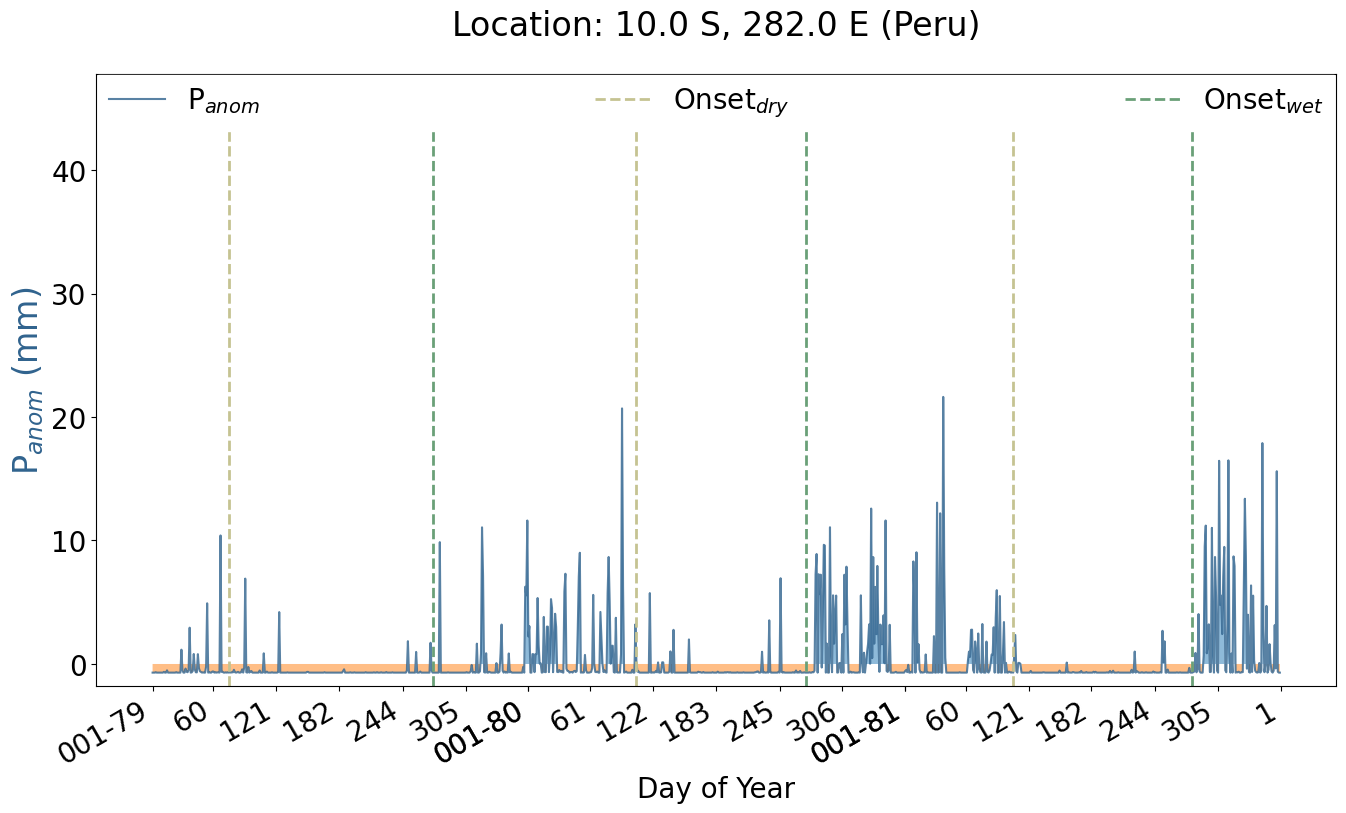

In [140]:
pp.plotOnsetTS(cpc_conus_anom, onset, demise, slice('1979','1981'), iloc=(20,10))

In [ ]:
reload(od)
reload(sf)
bom_demise = od.demise_B17(cpc_conus_anom,start_wet)
bom_onset = od.onset_B17(cpc_conus_anom,start_wet)


In [ ]:
sf.mean_doy(onset.isel(lat=20,lon=20).values)

In [ ]:
test = onset.isel(lat=20,lon=20).values

In [ ]:
mean_onset = xr.apply_ufunc(
    st.circmean,
    onset,
    input_core_dims=[['year']],
    output_core_dims=[[]],
    vectorize= True,
    dask = 'parallelized',
    kwargs={'nan_policy':'omit', 'high':365}
    
)

In [ ]:
mean_demise = xr.apply_ufunc(
    st.circmean,
    demise,
    input_core_dims=[['year']],
    output_core_dims=[[]],
    vectorize= True,
    dask = 'parallelized',
    kwargs={'nan_policy':'omit', 'high':365}
    
)

In [ ]:
pp.plot_spatial_data(mean_onset, title= 'Mean Onset of Wet Season', var='DOY')

In [ ]:
pp.plot_spatial_data(mean_demise, title= 'Mean Demise of Wet Season', var='DOY')

In [ ]:
peru_shp = '/Users/gbromley/Library/CloudStorage/Dropbox/Mac (2)/Downloads/per_adm_ign_20200714_shp'
import xarray as xr
import geopandas as gpd
import rioxarray
# Load climate dataset
climate_data = xr.open_dataarray('onset_LM01_peru.nc').isel(year=1)

# Load vector data
peru_outline = gpd.read_file(peru_shp)

# Set spatial coordinates and reproject if needed
climate_data = climate_data.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
climate_data = climate_data.rio.write_crs('EPSG:4326')

# Clip climate dataset to Peru's extent
clipped_data = climate_data.rio.clip(peru_outline.geometry, peru_outline.crs)

# Create mask based on Peru's outline
mask = clipped_data.rio.geometry_mask(peru_outline.geometry, peru_outline.crs)

# Apply mask to the clipped dataset
masked_data = clipped_data.where(mask)

# Save masked dataset to a new file
masked_data

In [169]:
testd = demise.isel(lat=20, lon=20)
demise_aligned = testd.roll(year=-1, roll_coords=True)
demise_aligned[-1] = np.nan

In [195]:
onset

<xarray.DataArray (lat: 41, lon: 33, year: 33)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [311., 240., 213., ..., 261., 235., 315.],
        [306., 240., 212., ..., 264., 238., 317.],
        [303., 237., 210., ..., 310., 279., 319.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [311., 240., 240., ..., 262., 235., 339.],
        [311., 240., 214., ..., 263., 236., 338.],
        [337., 240., 212., ..., 265., 239., 333.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [336., 313., 351., ..., 286., 292., 279.],
        [342., 291.,  nan, ..., 287., 290., 278.],
        [348., 289., 334., ..., 287., 289., 330.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [285.,  nan, 303., ..., 313., 293., 330.],
        [336., 358., 351., ..., 285., 292., 330.],
        [341., 354.,  nan, ..., 312., 291., 309.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [332.,  nan, 299., ..., 313., 292., 330.],
        [337., 357., 347., ..., 313., 319., 330.],
        [341., 353.,  nan, ..., 313., 319., 330.]]])
Coordinates:
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... -1.5 -1.0 -0.5 0.0
  * lon      (lon) float64 277.0 277.5 278.0 278.5 ... 291.5 292.0 292.5 293.0
  * year     (year) datetime64[ns] 1979-01-01 1980-01-01 ... 2011-01-01

In [ ]:
def calcDates(onset_da, demise_da):
    ### Convert days and year to dates, align demise and onset.
    
    
    
    

In [170]:
def calcSeasonPSum(onset_array, demise_array):
    

<xarray.DataArray (year: 33)>
array([ 86., 170., 122., 132., 171., 139., 153., 114., 155., 122., 124.,
       204., 207., 202., 168., 126., 116., 131., 141., 178., 202., 175.,
       128., 178., 128., 122., 162., 138., 175., 146.,  96.,   0.,  nan])
Coordinates:
    lat      float64 -10.0
    lon      float64 287.0
  * year     (year) datetime64[ns] 1980-01-01 1981-01-01 ... 1979-01-01

In [155]:
test = onset.isel(lat=20, lon=20)

In [78]:
int(test[0].values)

304

In [156]:
onset_dates = onset.year.values + pd.to_timedelta(test.values, unit='D')

In [173]:
demise_dates = demise_aligned.year.values + pd.to_timedelta(demise_aligned.values, unit='D')

In [164]:
onset_dates

DatetimeIndex(['1979-11-01', '1980-12-29', '1981-10-30', '1982-09-13',
               '1983-11-26', '1984-11-02', '1985-09-10', '1986-09-05',
               '1987-10-05', '1988-10-02', '1989-08-24', '1990-09-27',
               '1991-09-03', '1992-10-01', '1993-10-05', '1994-10-24',
               '1995-08-31', '1996-10-01', '1997-10-23', '1998-10-02',
               '1999-10-16', '2000-09-30', '2001-09-04', '2002-10-19',
               '2003-10-23', '2004-08-31', '2005-10-09', '2006-09-19',
               '2007-10-11', '2008-10-03', '2009-09-19', '2010-10-25',
               '2011-10-13'],
              dtype='datetime64[ns]', freq=None)

In [175]:
demise_dates - onset_dates

TimedeltaIndex(['147 days', '173 days', '185 days', '242 days', '207 days',
                '199 days', '266 days', '232 days', '243 days', '213 days',
                '254 days', '300 days', '327 days', '294 days', '256 days',
                '195 days', '239 days', '223 days', '211 days', '269 days',
                '279 days', '268 days', '247 days', '252 days', '198 days',
                '245 days', '246 days', '242 days', '257 days', '236 days',
                '200 days',  '68 days',        NaT],
               dtype='timedelta64[ns]', freq=None)

In [184]:
subset.sel(time=slice(onset_dates[0],demise_dates[0]))

<xarray.DataArray 'precipitation' (time: 148)>
array([2.0195358e+00, 6.6448081e-01, 5.5157242e+00, 6.5143824e+00,
       3.6738219e+00, 7.1996719e-02, 9.5463514e+00, 2.8988140e+01,
       4.8605328e+00, 1.1953184e+01, 2.4679855e+01, 1.0250056e+00,
       0.0000000e+00, 1.5666598e+00, 1.0194720e+01, 9.4895077e+00,
       4.6932977e-01, 1.9946038e+00, 3.1043306e-01, 3.1066595e+01,
       3.5517476e+00, 0.0000000e+00, 3.4984574e+00, 8.3050632e+00,
       2.8931446e+00, 3.6205189e+00, 4.1503472e+00, 0.0000000e+00,
       0.0000000e+00, 1.6407063e+00, 3.7706119e-01, 3.1526654e+00,
       8.7134406e-02, 7.2324812e-01, 3.3850050e-01, 6.5289955e+00,
       6.0283780e-01, 5.5079217e+00, 1.8238761e+00, 0.0000000e+00,
       7.2199950e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       6.9103196e-02, 9.4280882e+00, 0.0000000e+00, 5.3330362e-01,
       7.8951888e-02, 0.0000000e+00, 2.5670538e+01, 0.0000000e+00,
       1.2422259e+00, 0.0000000e+00, 2.7442880e+00, 0.0000000e+00,
       1.0727188e+01, 7.0765176e+00, 1.7912815e+00, 2.4141168e-02,
       1.2461153e+00, 3.3136265e+01, 3.8824646e+00, 2.3453340e-02,
       7.9436702e-01, 0.0000000e+00, 3.3512664e+00, 9.8730534e-01,
       0.0000000e+00, 0.0000000e+00, 8.4302741e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 3.3434894e+00, 9.6986520e-01,
       7.2857409e+00, 2.2315590e+01, 2.5650811e+00, 2.1997158e-01,
       1.9931841e+01, 1.4261053e+01, 3.0097584e+01, 1.6559511e+00,
       1.6459116e-01, 2.6737729e-01, 3.7731110e+01, 2.4060245e+00,
       1.1355318e+00, 0.0000000e+00, 3.7527103e+00, 0.0000000e+00,
       0.0000000e+00, 1.6164120e+01, 1.4037447e+01, 1.0926734e+01,
       2.1442589e-01, 0.0000000e+00, 2.6340237e-01, 2.6773462e+01,
       1.7612413e+01, 4.4639833e-02, 0.0000000e+00, 1.9975834e-01,
       0.0000000e+00, 0.0000000e+00, 3.1770539e+00, 1.6257922e-01,
       8.8417548e-01, 1.2469969e+01, 3.1655374e+00, 3.9175847e+00,
       3.3646584e+00, 9.8974552e+00, 6.2740054e+00, 0.0000000e+00,
       2.1719265e+01, 8.0245304e-01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 7.1297795e-02, 2.2368904e+01,
       3.4811707e+00, 0.0000000e+00, 1.9544192e-01, 2.4610257e-01,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.6250096e-01,
       6.5807498e-01, 0.0000000e+00, 1.0245802e+01, 4.2444970e-02,
       2.0121910e+01, 4.6044636e-01, 0.0000000e+00, 1.8299351e+01,
       3.2092223e-01, 1.7548746e+01, 3.9602852e+00, 1.1362059e+01,
       6.4414382e+00, 1.0945770e+00, 3.5949588e-02, 1.0665687e+00],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-11-01 1979-11-02 ... 1980-03-27
    lat      float64 -10.0
    lon      float64 287.0

In [189]:
for i, date in enumerate(onset_dates):
    
    print(subset.sel(time=slice(onset_dates[i],demise_dates[i])).sum().values)

730.9356
1021.47394
1646.5122
1712.96
1822.2505
1020.6594
1787.1595
1892.0978
1818.708
2074.7412
1576.4524
2154.1362
1655.8708
2224.5215
2459.4038
1427.5586
1999.0918
1889.9939
1201.6343
1932.8821
1988.5582
2092.8074
1939.7113
1748.0497
1327.5334
1601.0137
1421.0403
1530.1456
1768.7119
1612.0947
1034.0281
413.74612
329.22757


In [47]:
def seasonLength(onset, demise):
    
    demise_aligned = np.roll(demise, -1)
    demise_aligned[-1] = np.nan
    
    length = 365 - np.abs(onset - demise_aligned)
    
    
    return length

In [56]:
def calcSeasonLength(onset, demise):
    
    
    
    length = xr.apply_ufunc(
    seasonLength,
    onset,
    demise,
    input_core_dims=[['year'], ['year']],
    output_core_dims=[['year']],
    vectorize= True,
    dask = 'parallelized',    
)
            
            
    
    
    return length

In [59]:
wetLength = calcSeasonLength(onset, demise)

/Users/gbromley/opt/anaconda3/envs/peru/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


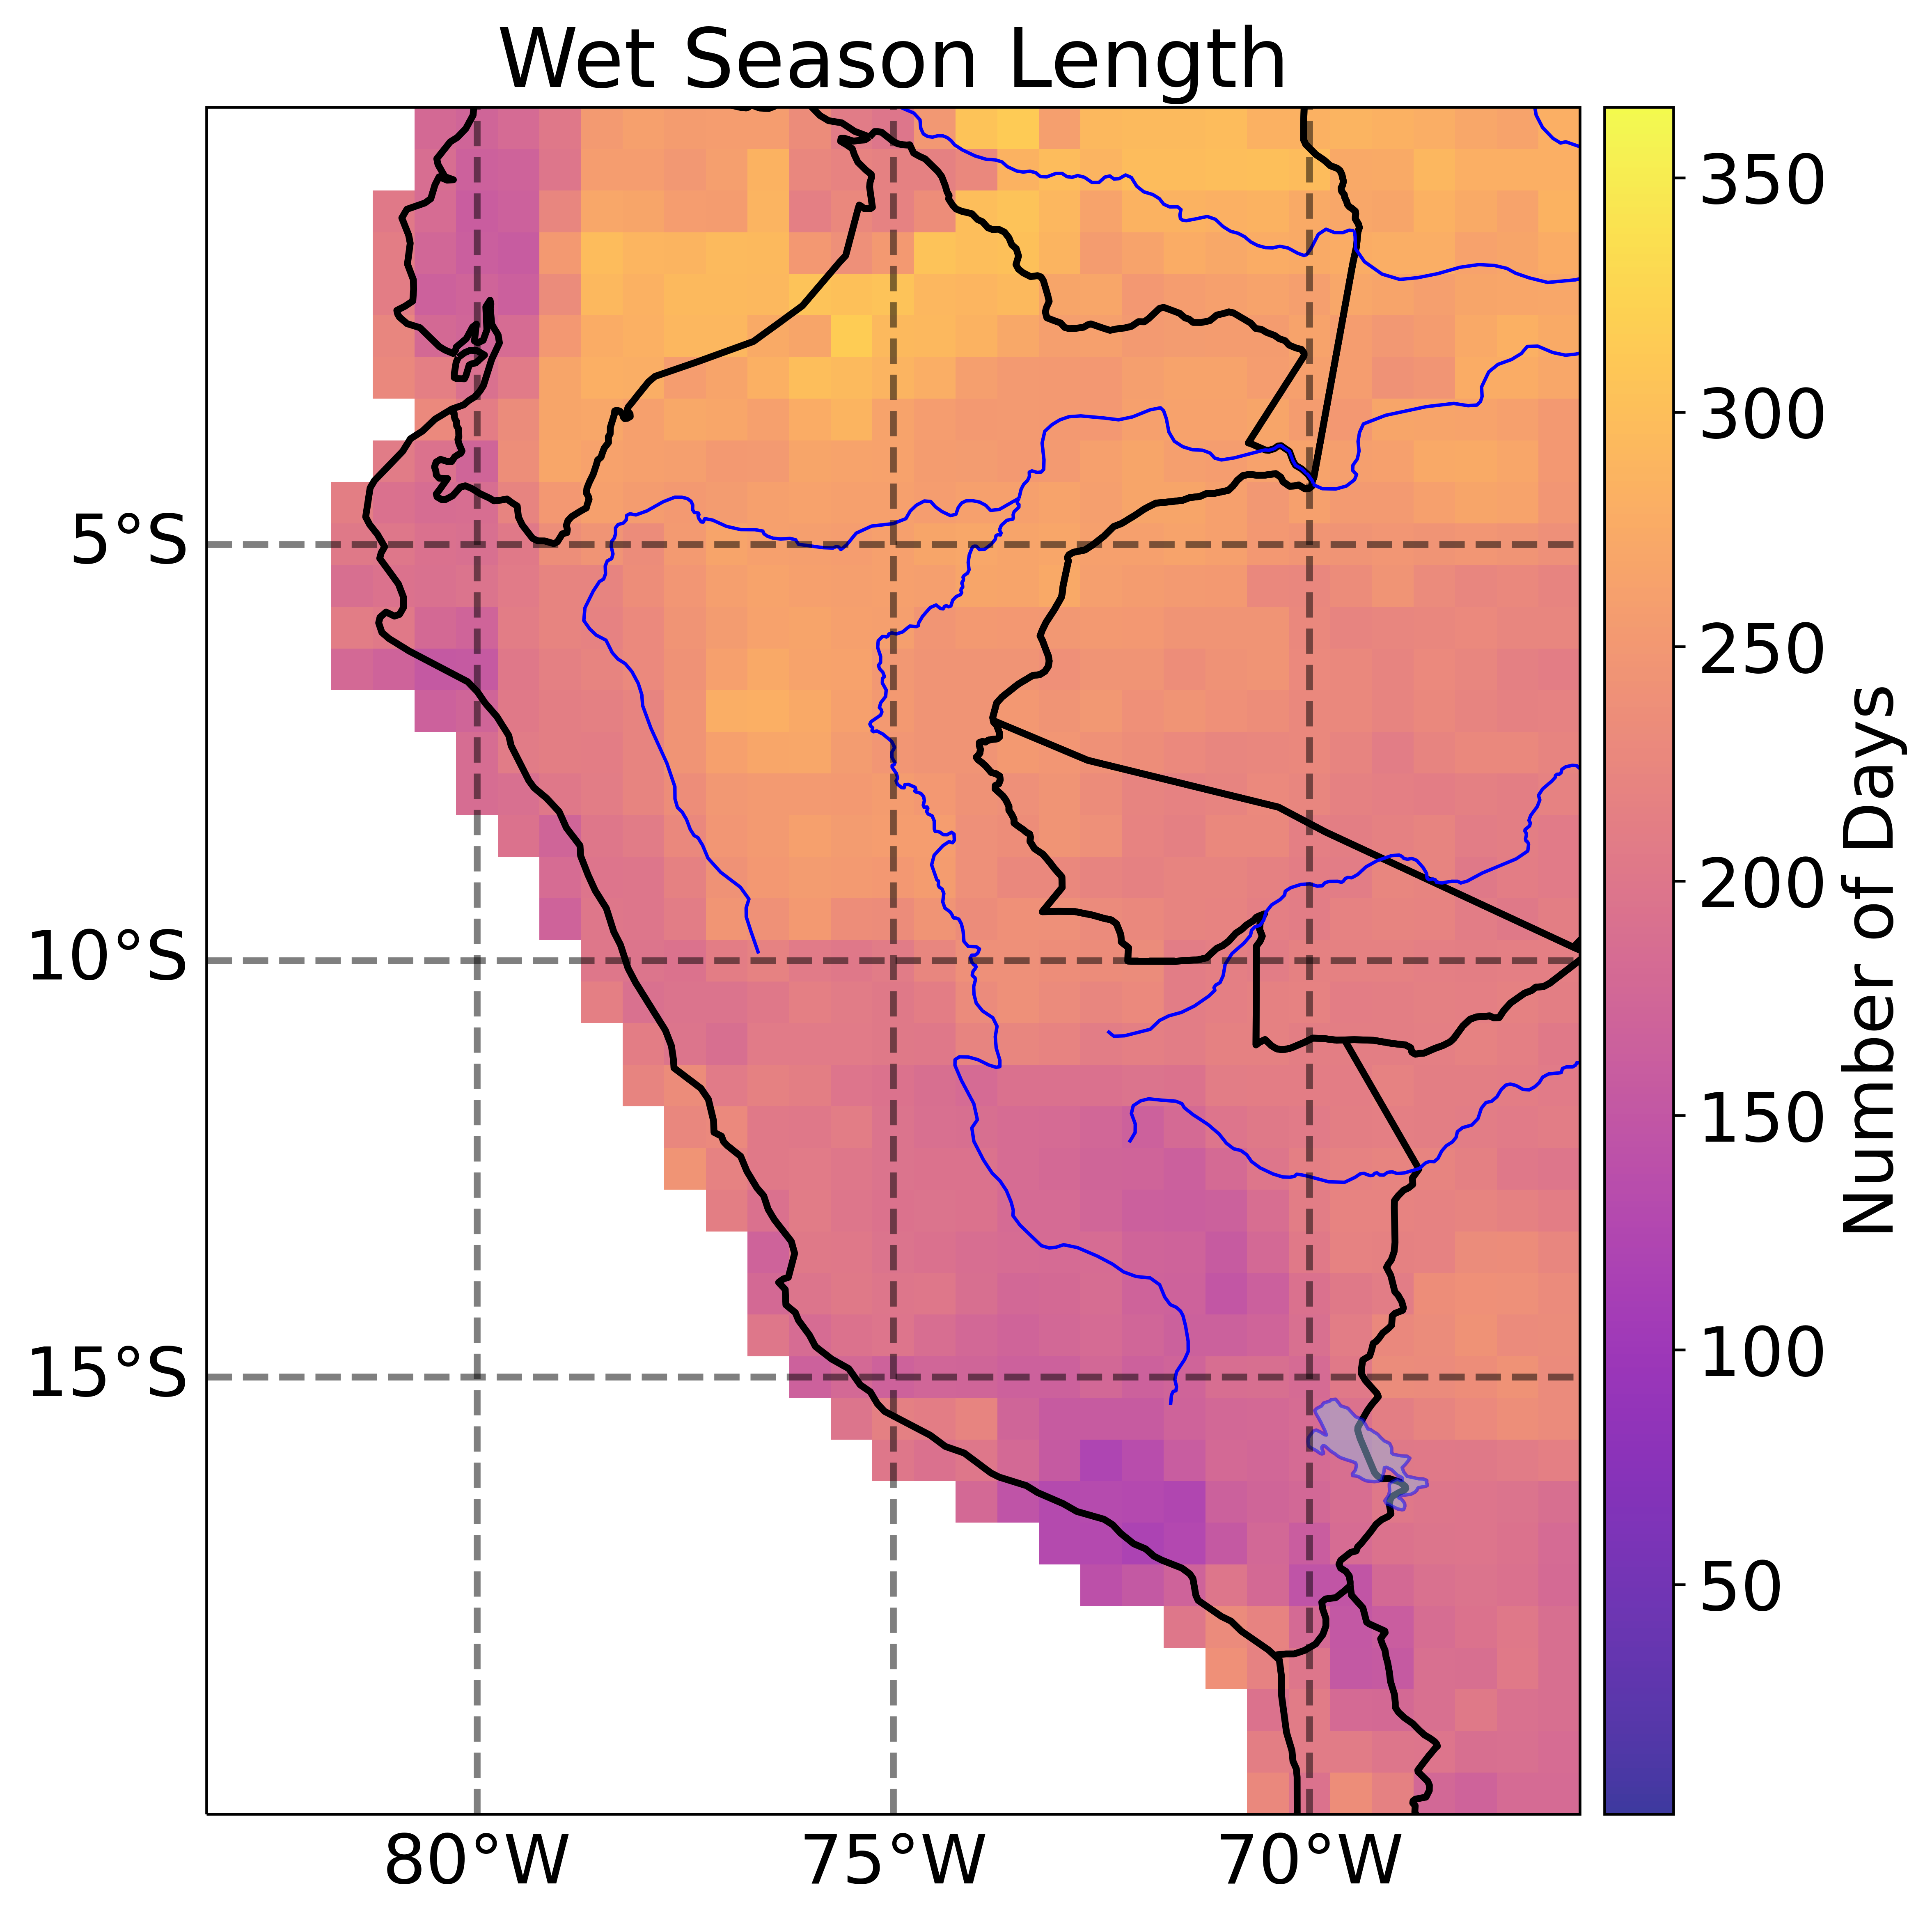

In [65]:
pp.plot_spatial_data(wetLength.mean(dim='year'), cmap='plasma', title = 'Wet Season Length', var='Number of Days')

In [ ]:
mean_onset = xr.apply_ufunc(
    st.circmean,
    onset,
    input_core_dims=[['year']],
    output_core_dims=[[]],
    vectorize= True,
    dask = 'parallelized',
    kwargs={'nan_policy':'omit', 'high':365}
    
)